# imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Initial data handling
The first step to a data science project is ensuring you understand your data. Copied from Kaggle, the features are:
- distance_from_home - the distance from home where the transaction happened.
- distance_from_last_transaction - the distance from the last transaction that happened.
- ratio_to_median_purchase_price - Ratio of purchased price to median purchase price.
- repeat_retailer - If the transaction happened from the same retailer.
- used_chip - If the transaction is through chip (credit card).
- used_pin_number - If the transaction used PIN.
- online_order - If the transaction is an online order.
- fraud - If the transaction is fraudulent.

In [2]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
assert (len(df) == len(df.drop_duplicates()))

In [5]:
def split_data(df, target=None):
    
    if target == None:
        target = list(df.columns)[-1]
    return df.drop(columns=[target], axis=1), df[[target]]

def nan_ratio_col(df, col):
    nan_ratio = sum(df[col].isna()) / len(df[col])
    return nan_ratio

In [6]:
# Splitting training and validation data
X, y = split_data(df)


If we split the dataset before dropping duplicates, a duplicate sample may be in both the train and test/validation splits. This is known as data leakage and it reduces the reliability of our evaluation metrics. To avoid this you must drop all duplicates before splitting your dataset. In this dataset, there are no duplicate values.


In [7]:
assert (len(df) == len(df.drop_duplicates()))

In [8]:

def split_data(df, target=None):
    # pre-written function from personal archive    
    if target == None:
        target = list(df.columns)[-1]
    return df.drop(columns=[target], axis=1), df[[target]]

# Splitting training and validation data
X, y = split_data(df)

# Feature engineering

I have decided to test two engineered features. The goal of feature engineering is to transform one or more features into a new feature that gives our ML model more predictive power by reducing noise or making complex patterns more simple (Typically by combining features in a meaningful way).

Feature engineering ideas:

- jumping_transaction Bool = (distance_from_last_transaction in 80th percentile) & online_order
- chip_and_pin Bool = used_chip & used_pin_number

The idea behind "jumping_transaction": Thinking about what fraud looks like as a human, if a transaction takes place online, and is far from the location of the last transaction, it is a cause for concern. So I will try this new feature.

The idea behind "chip_and_pin": "Chip and Pin" refers to a real-world payment method that maximises security. So I combined the 2 to check if it helped or hurt the model.

In [9]:
# jumping_transaction
distant_transaction_threshold = X["distance_from_last_transaction"].quantile(.8)
distant_transaction = X["distance_from_last_transaction"] > distant_transaction_threshold
X['jumping_transaction'] = (distant_transaction & X["online_order"]).astype(int)

In [10]:
#chip_and_pin
X["chip_and_pin"] = (X["used_chip"].astype(int) & X["used_pin_number"].astype(int))
X["chip_and_pin"].value_counts()

chip_and_pin
0    964947
1     35053
Name: count, dtype: int64

<!-- drop cols used in feature engineering to avoid multicolinearity/excess noise with no 
increased predictive power

The  -->

In [11]:

# final_features_fe = ["chip_and_pin", "jumping_transaction", "distance_from_home", "distance_from_last_transaction", "repeat_retailer", "ratio_to_median_purchase_price"]
# final_features_jt = ["jumping_transaction", "distance_from_home", "distance_from_last_transaction", "repeat_retailer", "ratio_to_median_purchase_price"]
# final_features_cnp = ["chip_and_pin", "distance_from_home", "distance_from_last_transaction", "repeat_retailer", "ratio_to_median_purchase_price"]
final_features_no_fe = ["used_chip", "used_pin_number", "online_order", "distance_from_home", "distance_from_last_transaction","repeat_retailer", "ratio_to_median_purchase_price"]
X = X[final_features_no_fe]
X

,jumping_transaction,distance_from_home,distance_from_last_transaction,repeat_retailer,ratio_to_median_purchase_price
0,0,57.877857,0.311140,1.0,1.945940
1,0,10.829943,0.175592,1.0,1.294219
2,0,5.091079,0.805153,1.0,0.427715
3,1,2.247564,5.600044,1.0,0.362663
4,0,44.190936,0.566486,1.0,2.222767
...,...,...,...,...,...
999995,0,2.207101,0.112651,1.0,1.626798
999996,0,19.872726,2.683904,1.0,2.778303
999997,0,2.914857,1.472687,1.0,0.218075
999998,0,4.258729,0.242023,1.0,0.475822


Distance from home is the only feature with a range significantly far from 0-1. It is also strongly positively skewed. The skewness of the data is very important, as outliers in the "distance_from_home" feature are much more likely in one class (fraudulent transactions) than in the other. Because of this, we won't use a Gaussian scaler on our data. We also won't be min-max scaling our data because tree-based models can handle divergent ranges among features.

(array([8.99423e+05, 6.27940e+04, 1.83130e+04, 7.82400e+03, 4.09700e+03,
        2.23400e+03, 1.47900e+03, 9.64000e+02, 6.38000e+02, 4.78000e+02]),
 array([  0.,  60., 120., 180., 240., 300., 360., 420., 480., 540., 600.]),
 <BarContainer object of 10 artists>)

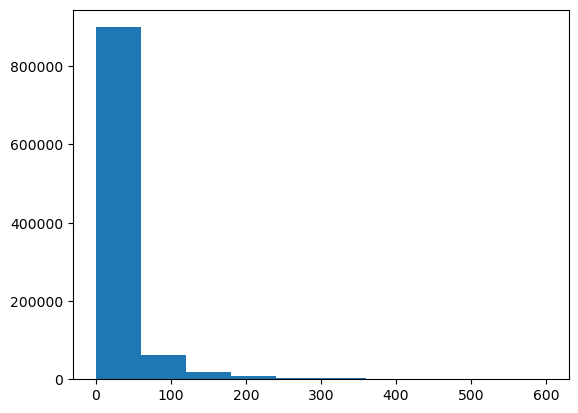

In [12]:
plt.hist(x=X["distance_from_home"],range=(0,600))

# Handling imbalanced dataset
The data is incredibly imbalanced. With fraudulent cases making up only ~10% of our samples. Oversampling would create excess noise, which I think is unnecessary so I'll use undersampling. With only 5 features and more than 87,000 samples in the minority class, I believe the model will have enough data to learn to differentiate each class. 

In [13]:
y.value_counts()

fraud
0.0      912597
1.0       87403
Name: count, dtype: int64

In [14]:
rus = RandomUnderSampler(random_state=42)
X_resample, y_resample = rus.fit_resample(X, y)

In [15]:
y_resample.value_counts()

fraud
0.0      87403
1.0      87403
Name: count, dtype: int64

It's important to tune your model based on the results on a test dataset, and to keep a separate final validation dataset to report to stakeholders. If you tune your model on test data and report the test metrics as your final model metrics, the model will inevitably underperform that score when applied to real unseen data. That is why we keep a validation dataset hidden until evaluation.

In [16]:
# splitting train/test and val datasets on resampled data
# Use resampled data because we have enough data to get accurate metrics without including the full dataset
X_train_rs, X_val_rs, y_train_rs, y_val_rs = train_test_split(
    X_resample, y_resample, test_size=0.2, random_state=42)


# Modelling

A good definition for Recall is "the fraction of relevant instances that were retrieved". In the case of fraud detection, we want to optimise the number of fraudulent transactions that our model detects. False positives are OK. 

In [17]:
# random search, grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.7, 0.8, 0.9, None],
    'min_impurity_decrease': [0.0, 0.0001, 0.001]
}

rs_obj = RandomizedSearchCV(
    RandomForestClassifier(), 
    distributions, 
    n_iter=2, 
    scoring="recall", 
    n_jobs=-1, 
    cv=2,
    random_state=42,
    )

In [18]:
rs_obj.fit(X_train_rs, y_train_rs)

/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was pa

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [0.7, 0.8, 0.9, None],
                                        'min_impurity_decrease': [0.0, 0.0001,
                                                                  0.001],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='recall')

In [19]:
pd.DataFrame(rs_obj.cv_results_)["mean_test_score"].mean()

0.9999213335587009

Unfortunately, my features did not improve the performance of the model. While Theory is useful in data science you do sometimes have to follow the empirical method typical of natural sciences. Hypothesis ("jumping_transaction" will improve the performance of the model), experiment (Calculate precision with and without "jumping_transaction" feature), and update your model (Remove "jumping_transaction" from the dataset.) 

In [22]:
print(f"No feature engineering    {0.9999356366410181}")
print(f"W  jumping transactions:  {0.9999213335587009}")
print(f"W  chip and pin:          {0.9998927257574414}")
print(f"W  both:                  {0.9998212109595901}")


No feature engineering    0.9999356366410181
W  jumping transactions:  0.9999213335587009
W  chip and pin:          0.9998927257574414
W  both:                  0.9998212109595901


# Evaluating

In [23]:
from sklearn.metrics import precision_score

In [26]:
best_model_predictions = rs_obj.best_estimator_.predict(X_val_rs)
best_model_precision = precision_score(best_model_predictions, y_val_rs)
print(f"The final score for the best version of the model is a precision of {best_model_precision}")

The final score for the best version of the model is a precision of 0.9998856358645929
